# Converting GMSH to OpenSeesPy

This GMSH case is derived from  [t1: Geometry basics, elementary entities, physical groups](https://gmsh.info/doc/texinfo/gmsh.html#t1).

First, we need to understand a few important concepts: ``dim``, ``entity``, and ``physical groups``.

## Dimensions, Entities, and Physical Groups in GMSH

### Dimensions (dim)

GMSH supports the following **geometric dimensions**:

- **0D**: Points, used to define vertices or key geometric features. (dim=0)
- **1D**: Lines, formed by connecting points, used for boundaries or linear structures. (dim=1)
- **2D**: Surfaces, enclosed areas formed by lines. (dim=2)
- **3D**: Volumes, closed regions formed by surfaces. (dim=3)

### Entities

Entities are the basic building blocks of the **geometry**:

- **Point entities**: Define key points or boundary features.
- **Line entities**: Represent boundaries or divisions of surfaces.
- **Surface entities**: Define areas for 2D mesh generation.
- **Volume entities**: Represent regions for 3D mesh generation.

### Physical Groups

Physical groups group entities to assign material properties, boundary conditions, or loads in simulations:

- **Purpose**: To label geometric features for simulation (e.g., load regions or boundary conditions).
- **Examples**:
  - A physical group can include multiple points, lines, surfaces, or volumes.
  - Simulations work with physical groups rather than individual entities.

.. Important::
    In the GMSH-to-OpenSeesPy conversion implemented by ``opstool``, the **names of the physical groups** are crucial. Physical group names are used to identify different nodes and elements. **Therefore, if you want to use physical groups, make sure to assign a unique name to each desired group!**

### An example

<img src="images/gmsh-t1.png" alt="t1 example" width="600">

In the examples above, we have two ways to identify geometry:
    
**(dim, entity_tag)**: 

- For points: [(0, 1), [0, 2], [0, 3], [0, 4]]
- For lines: [(1, 1), [1, 2], [1, 3], [1, 4]]
- For surfaces:[(2, 1)]

**Physical group**:

- name: "Boundary", include 4 lines and 4 points
- name: "Surface", include 1 surface.

.. Note::
    In GMSH, geometries are mutually exclusive.
    For example, Surface 1 does not include its boundary lines (1--4), 
    and Line 1--4 does not include its boundary points (1--4).
    This is a crucial point to note!

## GMSH model

Here, we use Python code to create a GMSH model. If you already have a generated ``.msh`` file, you can skip this section.
``opstool`` provides two methods to obtain GMSH data: **one is directly from memory**, and the other is by **reading a ``.msh`` file**. Both methods are equivalent.

In [1]:
import gmsh
import sys

gmsh.initialize()
gmsh.model.add("t1")

# points
# (dim, entity_tag) = [(0, 1), [0, 2], [0, 3], [0, 4]]
lc = 1e-2
gmsh.model.geo.addPoint(0, 0, 0, lc, tag=1)
gmsh.model.geo.addPoint(0.1, 0, 0, lc, tag=2)
gmsh.model.geo.addPoint(0.1, 0.3, 0, lc, tag=3)
gmsh.model.geo.addPoint(0, 0.3, 0, lc, tag=4)

# Lines
# (dim, entity_tag) = [(1, 1), [1, 2], [1, 3], [1, 4]]
gmsh.model.geo.addLine(1, 2, tag=1)
gmsh.model.geo.addLine(3, 2, tag=2)
gmsh.model.geo.addLine(3, 4, tag=3)
gmsh.model.geo.addLine(4, 1, tag=4)

gmsh.model.geo.addCurveLoop([4, 1, -2, 3], tag=1)

# Surface
# (dim, entity_tag) = [(2, 1)]
gmsh.model.geo.addPlaneSurface([1], tag=1)

gmsh.model.geo.synchronize()

# Important:
# Note that we use names to distinguish groups, so please do not overlook this!
# We use the "Boundary" group to include 4 lines and 4 corner points, which will later be used to specify the boundary conditions.
# The "Surface" group includes 1 surface, which will be used later to generate triangular elements!
gmsh.model.addPhysicalGroup(dim=0, tags=[1, 2, 3, 4], tag=1, name="Boundary")
gmsh.model.addPhysicalGroup(dim=1, tags=[1, 2, 3, 4], tag=2, name="Boundary")
gmsh.model.addPhysicalGroup(dim=2, tags=[1], tag=3, name="Surface")

# We can then generate a 2D mesh...
gmsh.model.mesh.generate(2)

# ... and save it to disk
# gmsh.write("t1.msh")


# if "-nopopup" not in sys.argv:
#     gmsh.fltk.run()

# This should be called when you are done using the Gmsh Python API:
# However, we still need to read data from GMSH, so we will keep it open for now and close
# it later after all the data has been read.
# gmsh.finalize()  # !!!!!!!!!!!!!!!!!!!!!!!

## GMSH to OpenSeesPy

In [2]:
import opstool as opst
import openseespy.opensees as ops

In [3]:
# Initialize GMSH to OpenSeesPy converter with 3D model and 6 degrees of freedom per node
GMSH2OPS = opst.pre.Gmsh2OPS(ndm=3, ndf=6)

# Read the saved .msh file generated by GMSH
# GMSH2OPS.read_gmsh_file("t1.msh")
GMSH2OPS.read_gmsh_data()
# Finalize and close, must after GMSH2OPS.read_gmsh_data()
gmsh.finalize()

Info:: Geometry Information >>>
9 Entities: 4 Point; 4 Curves; 1 Surfaces; 0 Volumes.

Info:: Physical Groups Information >>>
2 Physical Groups.
Physical Group names: ['Boundary', 'Surface']

Info:: Mesh Information >>>
404 Nodes; MaxNodeTag 404; MinNodeTag 1.
810 Elements; MaxEleTag 810; MinEleTag 1.



### By physical group

Here, we use physical groups to identify nodes and elements.

In [4]:
ops.wipe()
# Initialize a basic 3D model with 6 degrees of freedom per node
ops.model("basic", "-ndm", 3, "-ndf", 6)

# Define an elastic isotropic material
# Material ID: 1
# Elastic modulus: 2e8
# Poisson's ratio: 0.3
# Density: 7.85
ops.nDMaterial("ElasticIsotropic", 1, 2e8, 0.3, 7.85)

# Define a section using PlateFiber
# Section tag: 1
# Material tag: 1 (linked to the material defined above)
# Thickness: 0.005
secTag = 1
ops.section("PlateFiber", secTag, 1, 0.002)

In [5]:
GMSH2OPS.get_physical_groups()

{'Boundary': [(0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 4)],
 'Surface': [(2, 1)]}

Since we will read nodes and elements from GMSH, **element tags and node tags are not needed**.
You only need to input element parameters other than the element tags and node tags.

In [6]:
# Create OpenSeesPy node commands based on all nodes
GMSH2OPS.create_node_cmds()

# Create OpenSeesPy element commands for specific entities
# ASDShellT3 elements (3-node shell elements)
#
ele_tags = GMSH2OPS.create_element_cmds(
    ops_ele_type="ASDShellT3",  # OpenSeesPy element type
    ops_ele_args=[secTag],  # Additional arguments for the element (e.g., section tag)
    # Dimension-entity tags to specify which elements to create
    physical_group_names=["Surface"],
)

Using ASDShellT3 - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


Boundary conditions are specified using the "Boundary" physical group.

In [7]:
# fix_node_tags = GMSH2OPS.create_fix_cmds(
#     physical_group_names=["Boundary"], dofs=[1] * 6
# )

fix_node_tags = GMSH2OPS.get_node_tags(physical_group_names=["Boundary"])
for tag in fix_node_tags:
    ops.fix(tag, *[1] * 6)

In [8]:
# If there are too many geometries on the boundary, you can iterate through and extract
# all lines and points on a geometry using the following commands:

# This will extract all the boundaries on face with name Surface.
boundary_dim_tags = GMSH2OPS.get_boundary_dim_tags(
    physical_group_names="Surface", include_self=False
)
print(boundary_dim_tags)
print(GMSH2OPS.get_physical_groups()["Boundary"])
# # Create fix commands for the boundary with constraints applied to all 6 degrees of freedom (DOFs)
# fix_node_tags = GMSH2OPS.create_fix_cmds(
#     dim_entity_tags=boundary_dim_tags, dofs=[1] * 3
# )

[(0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 4)]
[(0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 4)]


OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

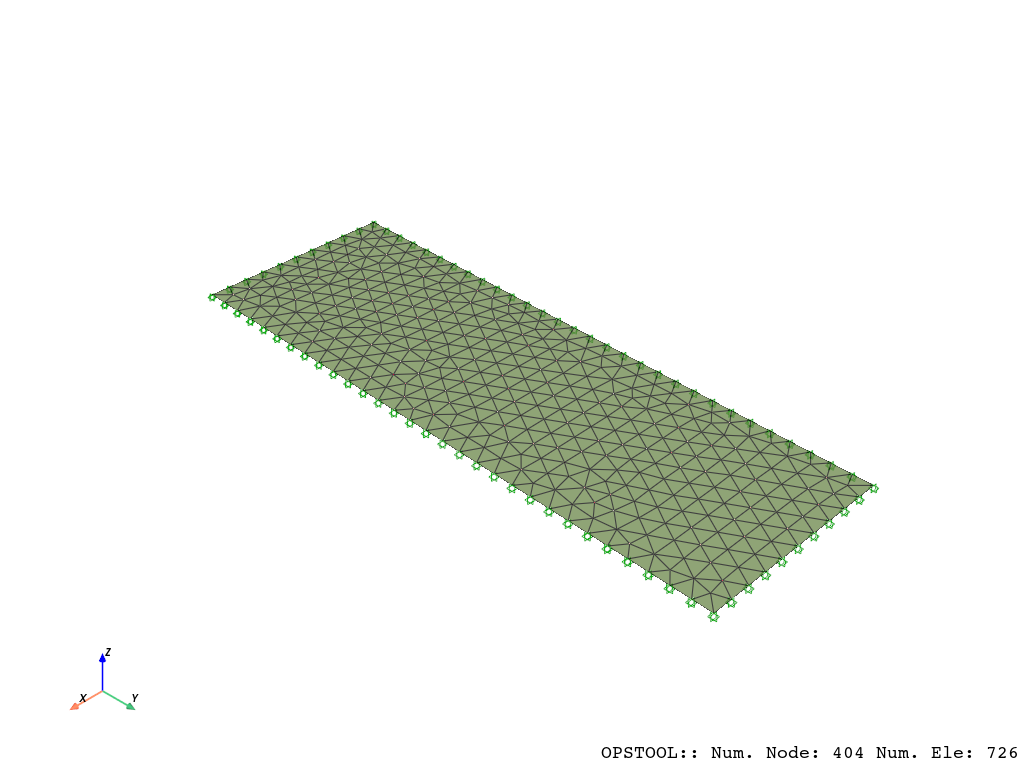

In [9]:
opst.vis.pyvista.set_plot_props(
    point_size=0,
    notebook=True,
    mesh_opacity=0.75,
)
plotter = opst.vis.pyvista.plot_model()
plotter.show(jupyter_backend="jupyterlab")
# plotter.show()

It can also be saved to a file.

In [10]:
# GMSH2OPS.set_output_file("t1_ops.py")
# # GMSH2OPS.set_output_file("t1_ops.tcl")
# GMSH2OPS.write_node_file()
# GMSH2OPS.write_element_file(
#     ops_ele_type="ASDShellT3",  # OpenSeesPy element type
#     ops_ele_args=[secTag],  # Additional arguments for the element (e.g., section tag)
#     # Dimension-entity tags to specify which elements to create
#     physical_group_names=["Surface"],
# )
# GMSH2OPS.write_fix_file(physical_group_names=["Boundary"], dofs=[1] * 6)

### By (dim, entity_tag)

Here, we use dimensions and entity tags to identify nodes and elements.

In [11]:
ops.wipe()
# Initialize a basic 3D model with 6 degrees of freedom per node
ops.model("basic", "-ndm", 3, "-ndf", 6)

# Define an elastic isotropic material
# Material ID: 1
# Elastic modulus: 2e8
# Poisson's ratio: 0.3
# Density: 7.85
ops.nDMaterial("ElasticIsotropic", 1, 2e8, 0.3, 7.85)

# Define a section using PlateFiber
# Section tag: 1
# Material tag: 1 (linked to the material defined above)
# Thickness: 0.005
secTag = 1
ops.section("PlateFiber", secTag, 1, 0.002)

Since we will read nodes and elements from GMSH, **element tags and node tags are not needed**.
You only need to input element parameters other than the element tags and node tags.

In [12]:
# Create OpenSeesPy node commands based on all nodes
GMSH2OPS.create_node_cmds()

# Create OpenSeesPy element commands for specific entities
# ASDShellT3 elements (3-node shell elements)
#
ele_tags = GMSH2OPS.create_element_cmds(
    ops_ele_type="ASDShellT3",  # OpenSeesPy element type
    ops_ele_args=[secTag],  # Additional arguments for the element (e.g., section tag)
    # Dimension-entity tags to specify which elements to create
    dim_entity_tags=[(2, 1)],
)

In [13]:
# Define boundary conditions
# Get the boundary dimension tags for the surface
boundary_dim_tags = GMSH2OPS.get_boundary_dim_tags([(2, 1)])
print("Boundary dim_tags:", boundary_dim_tags)
# Create fix commands for the boundary with constraints applied to all 6 degrees of freedom (DOFs)
fix_node_tags = GMSH2OPS.create_fix_cmds(
    dim_entity_tags=boundary_dim_tags, dofs=[1] * 6
)

Boundary dim_tags: [(0, 1), (0, 2), (0, 3), (0, 4), (1, 1), (1, 2), (1, 3), (1, 4)]


Using DomainModalProperties - Developed by: Massimo Petracca, Guido Camata, ASDEA Software Technology


OPSTOOL ::  Eigen data has been saved to _OPSTOOL_ODB/EigenData-None.nc!

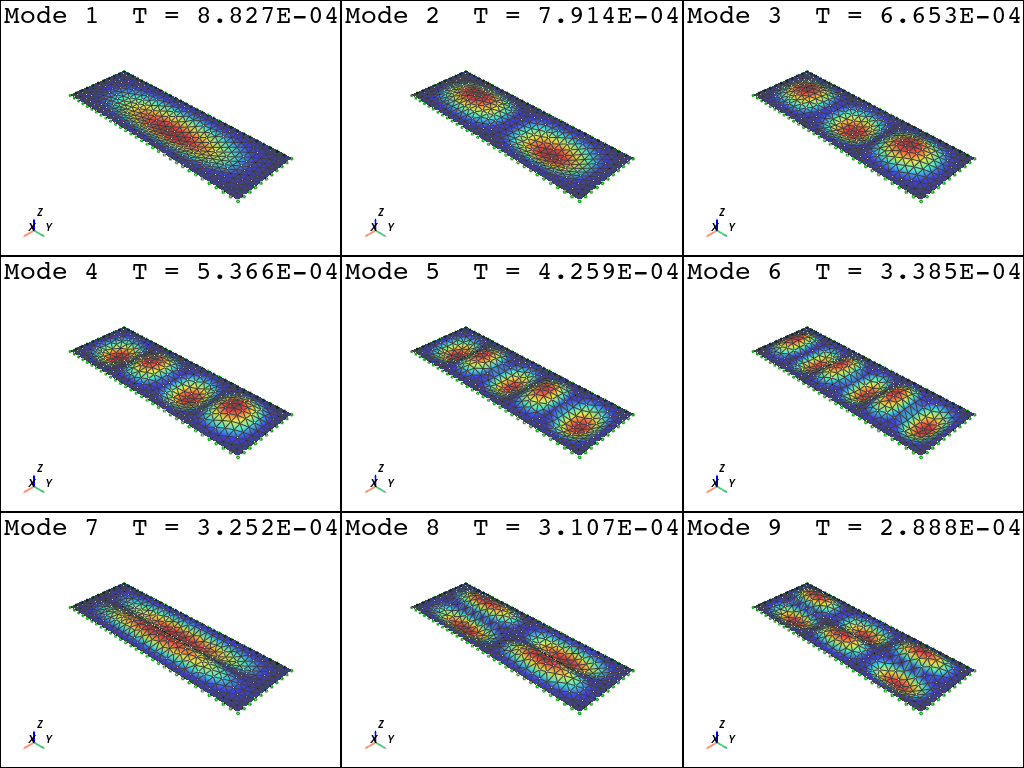

In [14]:
plotter = opst.vis.pyvista.plot_eigen([1, 9], subplots=True)
plotter.show(jupyter_backend="jupyterlab")
# plotter.show()